In [222]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
plt.rcParams['figure.figsize'] = [25, 8]


In [223]:
co2 = pd.read_csv('./co2.csv')
y_vals = co2['CO2Levels'].tolist()
x_vals = [*range(len(co2))]


# Actuals

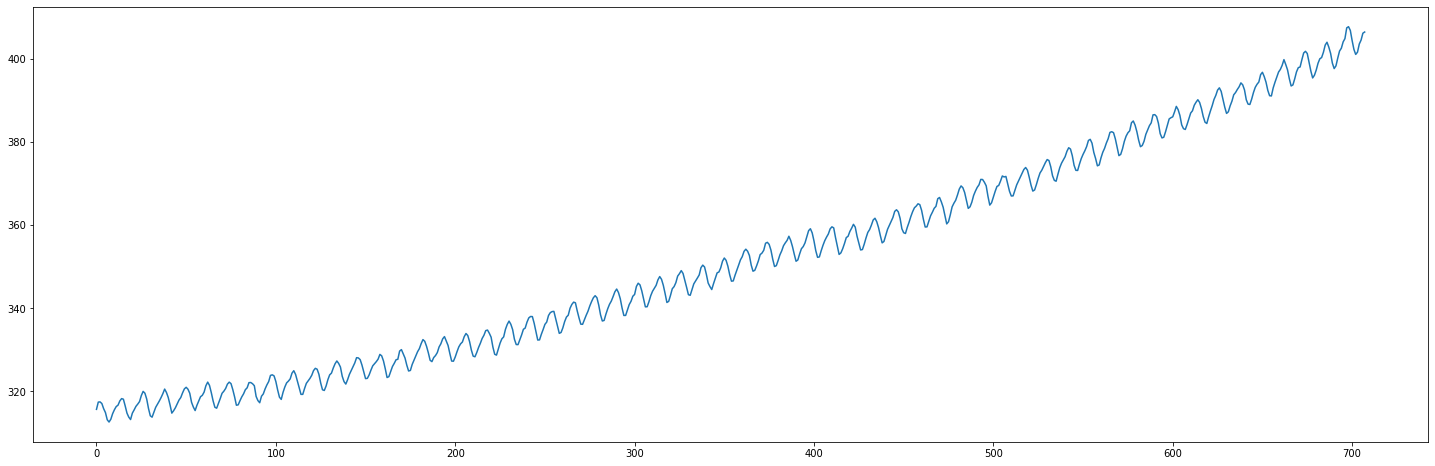

In [224]:

plt.plot(co2)

# Decomposed with Statsmodels

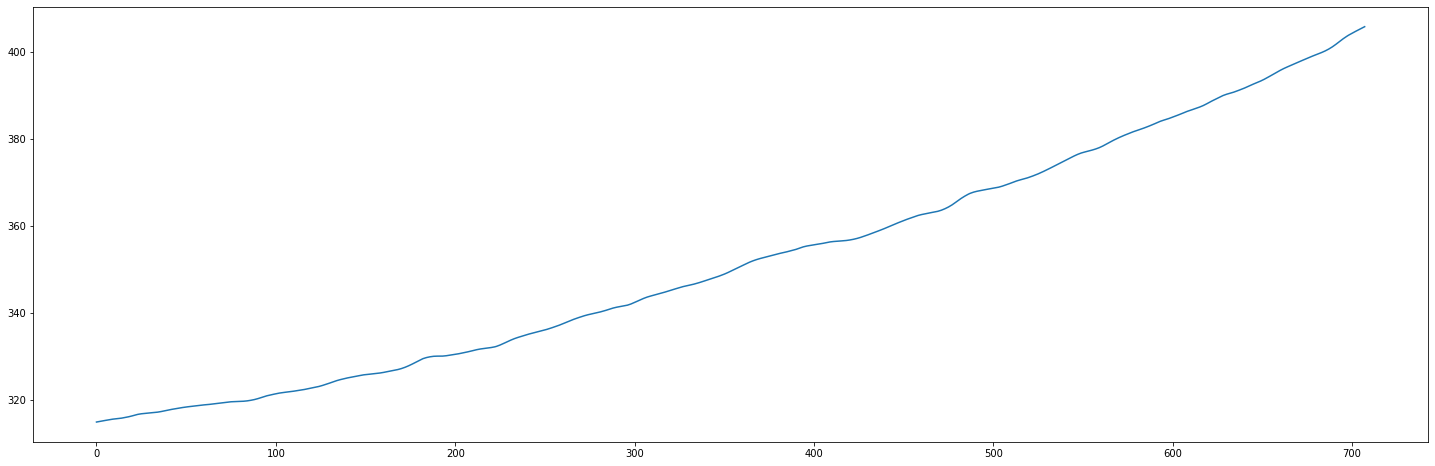

In [225]:
stl = STL(co2, period=12, seasonal=35, trend=19, low_pass=13)
res = stl.fit()
plt.plot(res.trend)

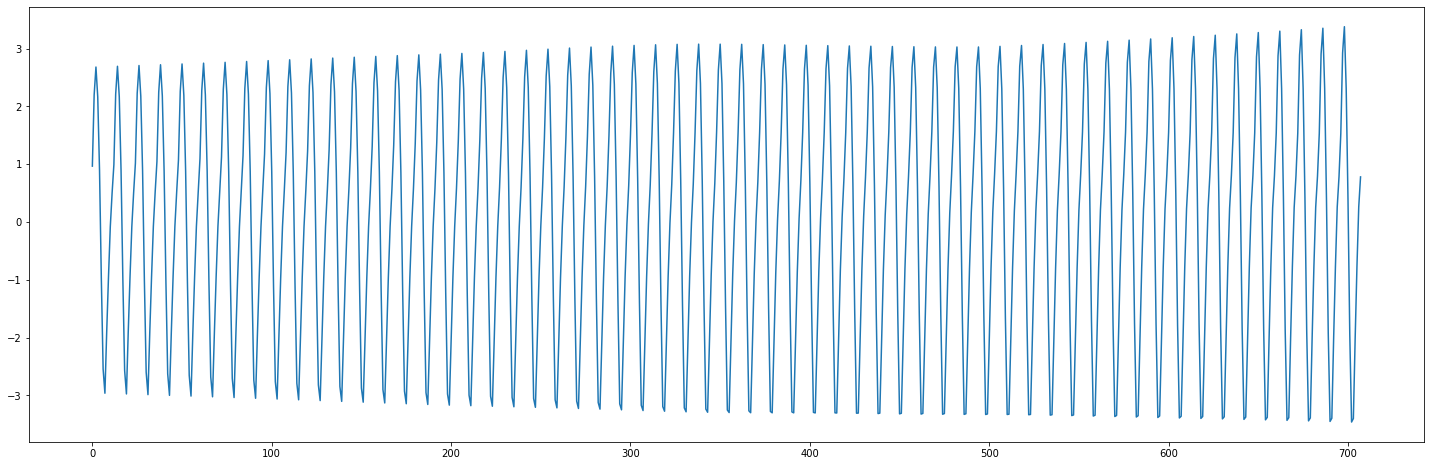

In [226]:
plt.plot(res.seasonal)

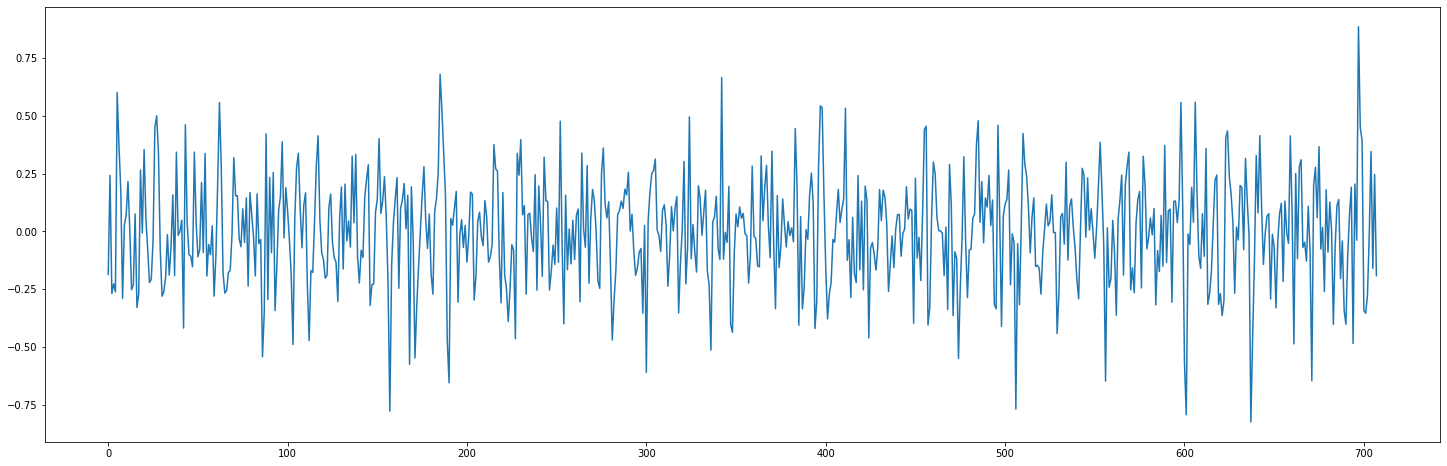

In [227]:
plt.plot(res.resid)

### STL Parameters

In [228]:
period = 12
n = len(y_vals)
ns = 35
nl = 13
nt = 19

### Step 2: cycle-subseries smoothing
Split the data insto cycle-subseries and smooth with loess. Also need to interpolate a cycle before and after the original data. I'm using a naieve approach by setting the first and last subseries values to be equal to be the real subseries data at index 0 and n / period respectively. Actual algorithm uses loess to impute.


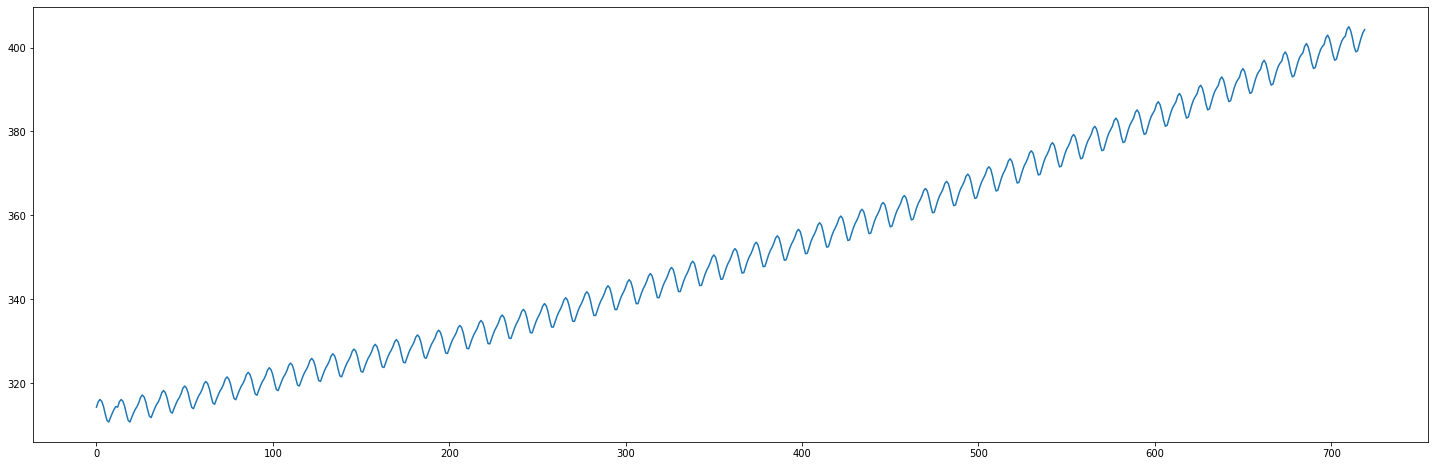

In [237]:
seasonal = [None] * (n + (2*period))
cycle_x_vals = [*range(0,math.ceil(n/period))]
for i in range(period) :
    cycle = []
    for j in range(i, n, period) :
        cycle.append(y_vals[j])
    smooth_cycle = lowess(cycle, cycle_x_vals, frac=(ns/float((n/period))), it=0)
    seasonal[i] = smooth_cycle[0,1]
    seasonal[n + i] = smooth_cycle[58,1]
    smooth_cycle_index = 0
    for k in range(i+period, n+period, period) : 
        seasonal[k] = smooth_cycle[smooth_cycle_index,1]
        smooth_cycle_index += 1
plt.plot(seasonal)

### Step 3: low-pass filtering of step 2
Also removes the extra cycles from the last step

In [238]:

low_pass_xvals = [*range(len(seasonal))]
low_pass = pd.DataFrame(seasonal, columns=['values']).transform(lambda x: x.rolling(period, 1).mean())
low_pass = low_pass.transform(lambda x: x.rolling(period, 1).mean())
low_pass = low_pass.transform(lambda x: x.rolling(3, 1).mean())
low_pass_lowess = lowess(low_pass['values'].tolist(), low_pass_xvals, frac=(nl/n), it=0)
low_pass = low_pass_lowess[:,1]
low_pass = low_pass[period:n+period]
seasonal = seasonal[period:n+period]


### Step 4: detrending smoothed cycle-subseries
seasonal = step 2 - step 3

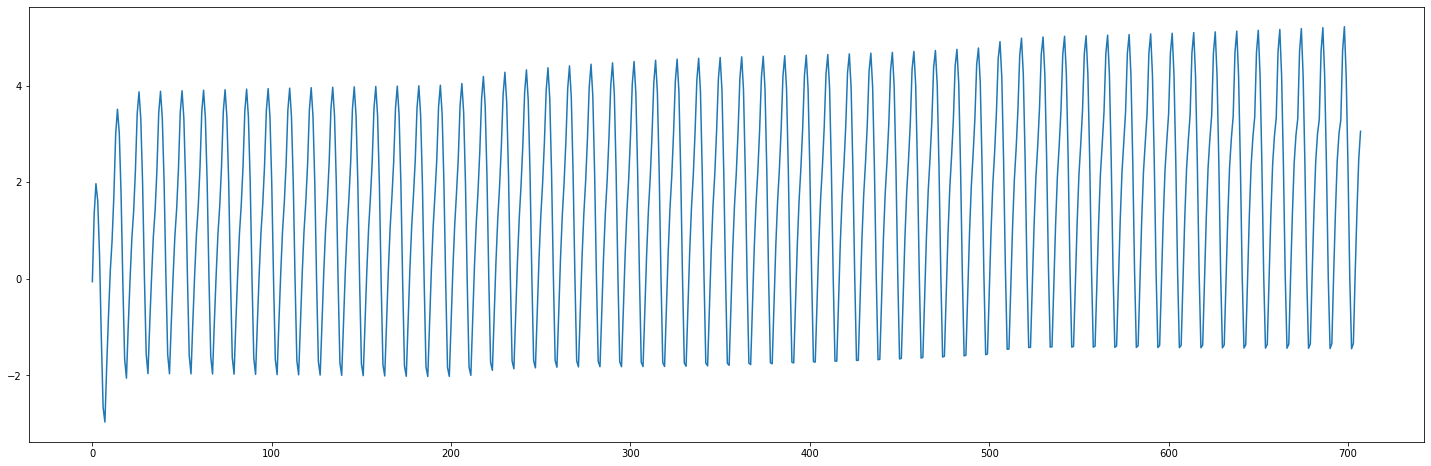

In [239]:
seasonal_df = pd.DataFrame(seasonal, columns=['values'])
low_pass_df = pd.DataFrame(low_pass, columns=['values'])
seasonal_df = seasonal_df.sub(low_pass_df)
plt.plot(seasonal_df)


### Step 5: Deseasonalizing
deseasonal = actuals - step 4

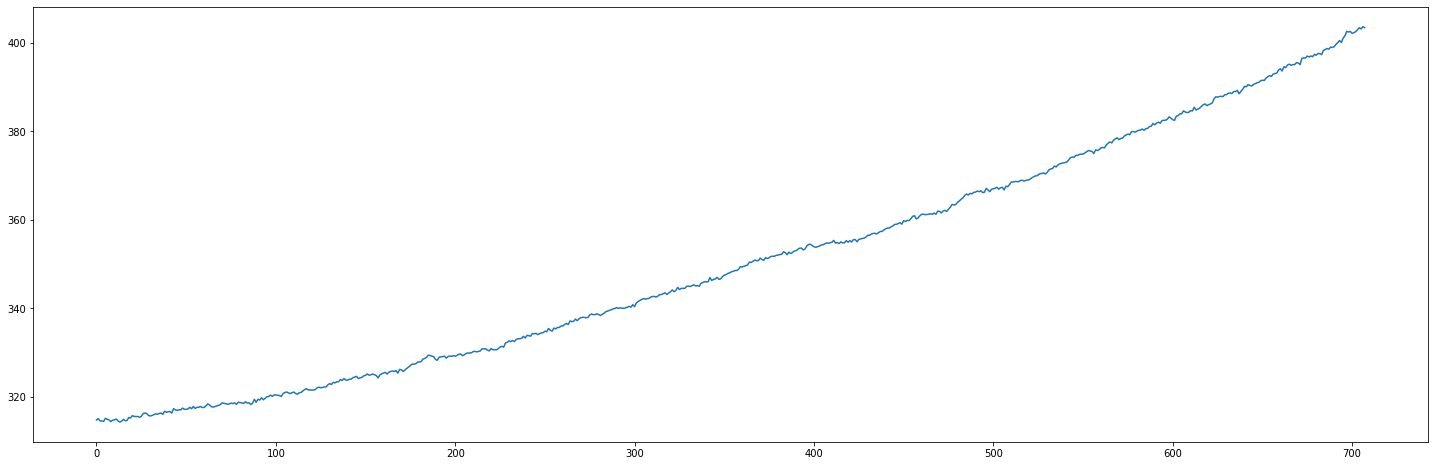

In [211]:
deseasonal = co2["CO2Levels"].sub(seasonal_df["values"])

plt.plot(deseasonal)

### Step 6: trend smoothing

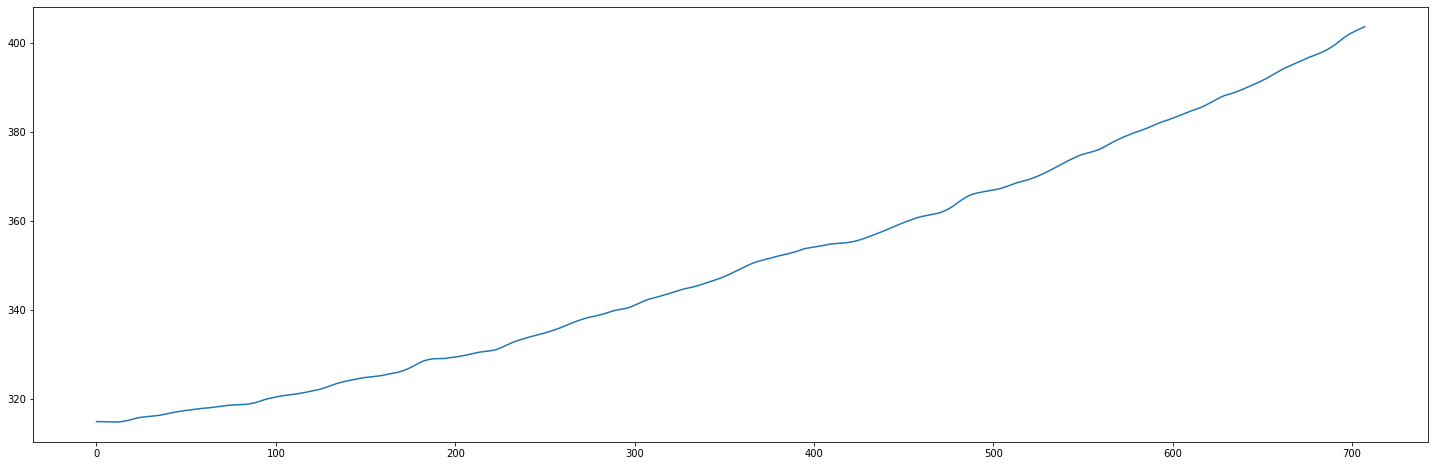

In [212]:
trend = lowess(deseasonal, x_vals, frac=(nt/n), it=0)
plt.plot(trend[:,1])

### Functions and constants for the steps defined above

In [213]:
period = 12
n = len(y_vals)
ns = 35
nl = 13
nt = 19

This version of cycle_subseries_smoothing imputes the extra cycle then smooths while the uncommented version does the opposite. Not sure which one's correct but it doesn't seem to make a difference.

In [214]:
# def cycle_subseries_smoothing(seasonal, period, n, ns) :
#     new_seasonal = [None] * (n + (2*period))
#     cycle_x_vals = [*range(0,math.ceil(n/period) + 2)]
#     for i in range(period) :
#         cycle = []
#         for j in range(i, n, period) :
#             cycle.append(seasonal[j])
#         cycle = [cycle[0]] + cycle + [cycle[len(cycle) -1]]
#         smooth_cycle = lowess(cycle, cycle_x_vals, frac=(ns/float((n/period))), it=0)
#         smooth_cycle_index = 0
#         for k in range(i, n + (2*period), period) : 
#             new_seasonal[k] = smooth_cycle[smooth_cycle_index,1]
#             smooth_cycle_index += 1
#     return new_seasonal

In [215]:
def cycle_subseries_smoothing(seasonal, period, n, ns) :
    new_seasonal = [None] * (n + (2*period))
    cycle_x_vals = [*range(0,math.ceil(n/period))]
    for i in range(period) :
        cycle = []
        for j in range(i, n, period) :
            cycle.append(seasonal[j])
        smooth_cycle = lowess(cycle, cycle_x_vals, frac=(ns/float((n/period))), it=0)
        new_seasonal[i] = smooth_cycle[0,1]
        new_seasonal[n + i] = smooth_cycle[58,1]
        smooth_cycle_index = 0
        for k in range(i+period, n+period, period) : 
            new_seasonal[k] = smooth_cycle[smooth_cycle_index,1]
            smooth_cycle_index += 1
    return new_seasonal

In [216]:
def low_pass_filter(seasonal, period, nl) :
    low_pass_xvals = [*range(len(seasonal))]
    seasonal_df = pd.DataFrame(seasonal, columns=['values'])
    low_pass = seasonal_df.transform(lambda x: x.rolling(period, 1).mean())
    low_pass = low_pass.transform(lambda x: x.rolling(period, 1).mean())
    low_pass = low_pass.transform(lambda x: x.rolling(3, 1).mean())
    low_pass_lowess = lowess(low_pass['values'].tolist(), low_pass_xvals, frac=(nl/n), it=0)
    low_pass = low_pass_lowess[:,1]
    return low_pass

In [217]:
def detrend_cycle_subseries(seasonal, low_pass) :
    seasonal_df = pd.DataFrame(seasonal, columns=['values'])
    low_pass_df = pd.DataFrame(low_pass, columns=['values'])
    seasonal_detrend_df = seasonal_df.sub(low_pass_df, axis=0)
    return seasonal_detrend_df

### Basic STL Algorithm
this for loop implements a basic STL algorithm using the functions defined above and statsmodel's Lowess function with 2 inner loop iterations and 0 outer loop iterations (outer loop not implemented). One exception is how extra cycle-subseries are imputed as described in step 2. I belive this is why the beginning doesn't quite match statsmodels STL.

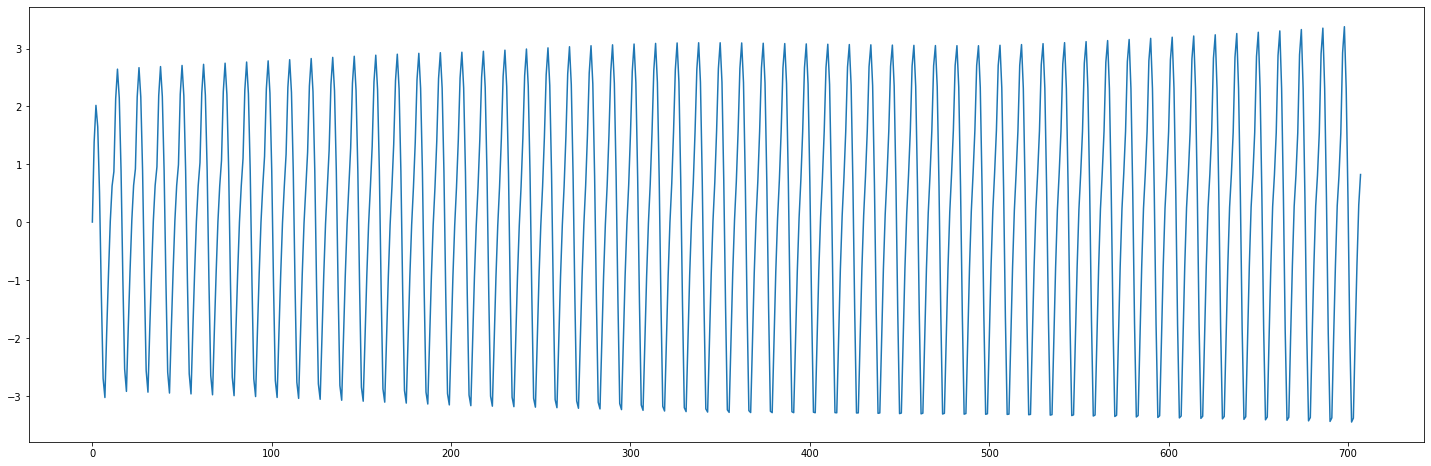

In [241]:
trend = [0] * n
#seasonal = y_vals
for i in range(2):
    seasonal = pd.DataFrame(y_vals, columns=['values']).sub(pd.DataFrame(trend, columns=['values']))
    seasonal = cycle_subseries_smoothing(seasonal['values'].tolist(), period, n, ns)
    low_pass = low_pass_filter(seasonal, period, nl)
    low_pass = low_pass[period:n+period]
    seasonal = seasonal[period:n+period]
    seasonal_df = detrend_cycle_subseries(seasonal, low_pass)
    seasonal = seasonal_df["values"].tolist()
    deseasonal_df = co2["CO2Levels"].sub(seasonal_df["values"])
    trend = lowess(deseasonal_df, x_vals, frac=(nt/n), it=0)
    trend = trend[:,1]
detrend = pd.DataFrame(y_vals, columns=['values']).sub(pd.DataFrame(trend, columns=['values']))
residual = detrend.sub(pd.DataFrame(seasonal, columns=['values']))
plt.plot(seasonal)


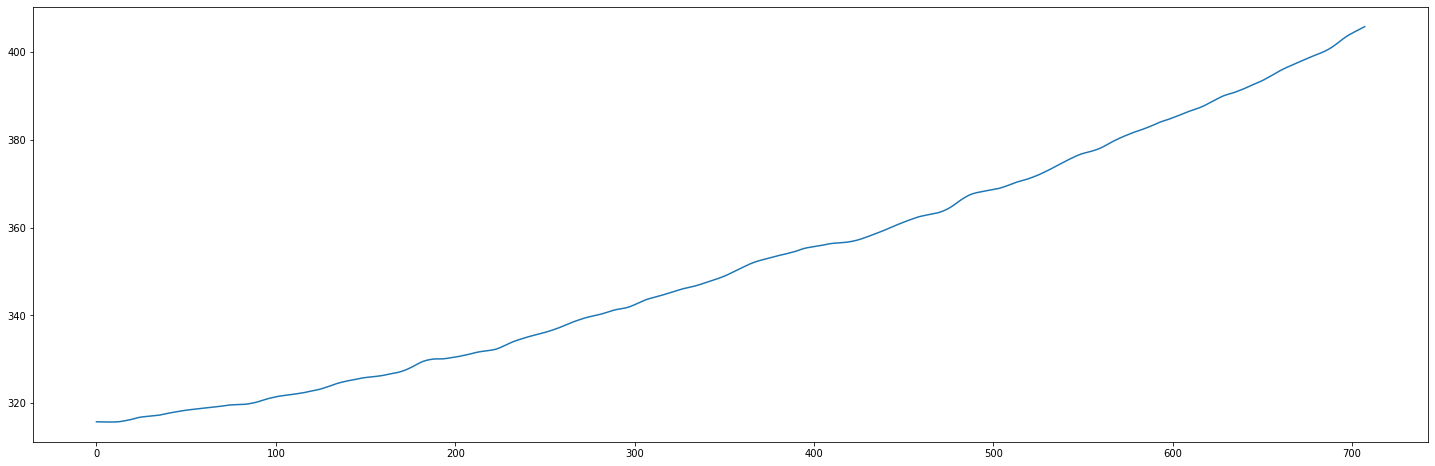

In [242]:
plt.plot(trend)

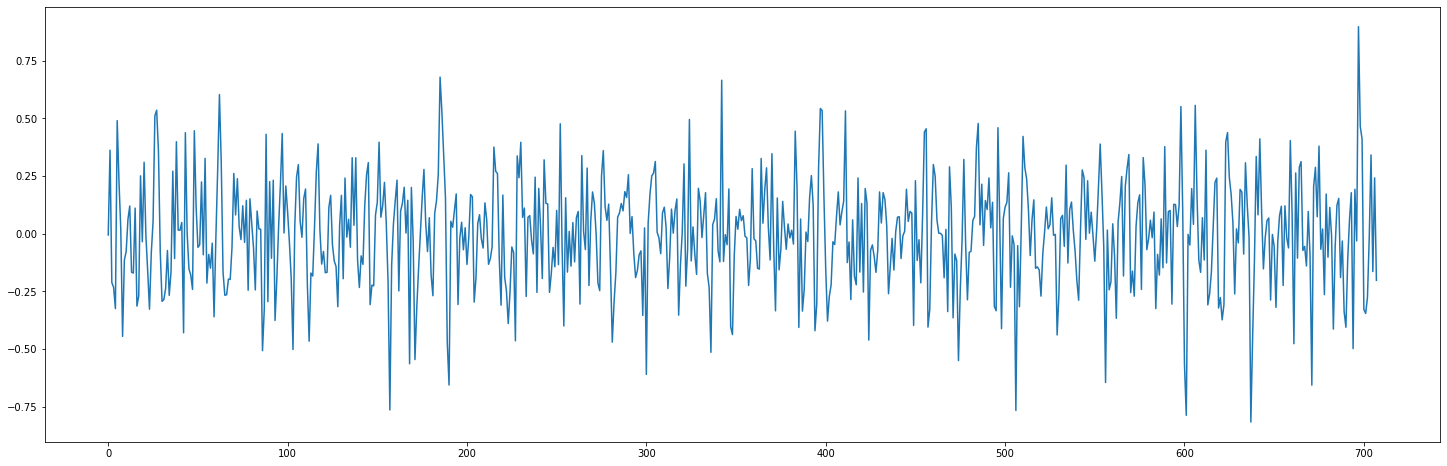

In [244]:
plt.plot(residual)

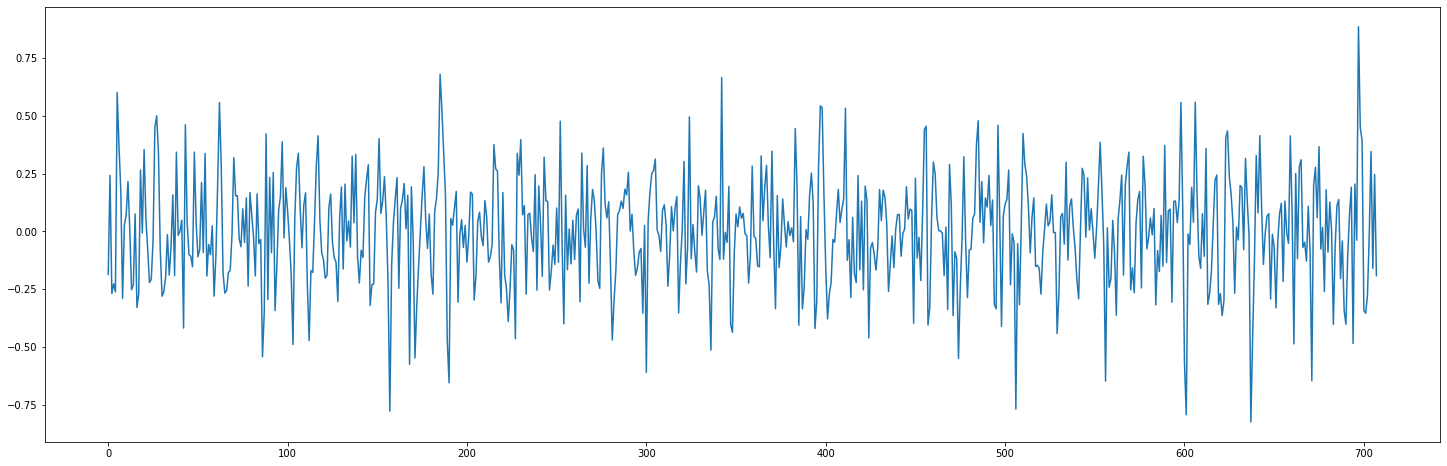

In [245]:
plt.plot(res.resid)